# Summary
- Analysis of fine-tuned models

In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import basename, dirname
import torch
import seaborn as sns
from ipywidgets import FloatSlider, interactive
import sys
sys.path.append('..')
from var import fname2mname, network2pair, network_sort_key

In [3]:
# loading in them all made my machine run out of memory
method_l = [
     "maxcorr", 
     "mincorr", 
     "maxlinreg", 
     "minlinreg", 
    "cca", 
    "lincka", 
    # "rbfcka",
]

In [4]:
# Set `res_d`, `network_l`, `num_neurons_d`
base = "/data/sls/temp/belinkov/contextual-corr-analysis/repr_fine_results1_"
res_fname = {method : base + method for method in 
                method_l}

res_d = {}
for method in method_l:
    with open(res_fname[method], 'rb') as f:
        res_d[method] = pickle.load(f)

network_l = [network for network in res_d["cca"]["corrs"]]
network_l = sorted(network_l, key=network_sort_key)

num_neurons_d = {}
for network in network_l:
    num_neurons_d[network] = len(next(iter(res_d["cca"]["corrs"][network].values()))) # god this is a hack

In [5]:
network_l

['bert_base_uncased-ptb_pos_dev.hdf5_0',
 'bert_base_uncased-ptb_pos_dev.hdf5_1',
 'bert_base_uncased-ptb_pos_dev.hdf5_2',
 'bert_base_uncased-ptb_pos_dev.hdf5_3',
 'bert_base_uncased-ptb_pos_dev.hdf5_4',
 'bert_base_uncased-ptb_pos_dev.hdf5_5',
 'bert_base_uncased-ptb_pos_dev.hdf5_6',
 'bert_base_uncased-ptb_pos_dev.hdf5_7',
 'bert_base_uncased-ptb_pos_dev.hdf5_8',
 'bert_base_uncased-ptb_pos_dev.hdf5_9',
 'bert_base_uncased-ptb_pos_dev.hdf5_10',
 'bert_base_uncased-ptb_pos_dev.hdf5_11',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_0',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_1',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_2',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_3',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_4',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_5',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_6',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_7',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_8',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_9',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_10',

# MaxCorr, MinCorr, MaxLinReg, MinLinReg

### Sorts

In [6]:
rk_methods = {"maxcorr", "mincorr", "maxlinreg", "minlinreg"}

In [7]:
neuron_sorts = {network: {} for network in network_l}
for network in network_l:
    for method in rk_methods:
        neuron_sorts[network][method] = res_d[method]["neuron_sort"][network]

In [8]:
# Set `rk_ar_d`, `rk_df_d`, `spearman_d`
rk_ar_d = {}
rk_df_d = {}
spearman_d = {}
for network in network_l:
    # rk_ar[method_ix, neuron] = rank
    # need to invert the permutation
    rk_ar = np.stack([
            [neuron_sorts[network][method].index(neuron) for neuron in range(len(neuron_sorts[network][method]))]
                      for method in rk_methods
    ]).T
    rk_df = pd.DataFrame(rk_ar, columns=list(rk_methods))
    
    rk_ar_d[network] = rk_ar
    rk_df_d[network] = rk_df
    spearman_d[network] = rk_df.corr()

In [9]:
for network in network_l:
    print(network)
    # print(rk_df_d[network])
    print(spearman_d[network])

bert_base_uncased-ptb_pos_dev.hdf5_0
           maxlinreg  minlinreg   maxcorr   mincorr
maxlinreg   1.000000   0.313669  0.835308  0.195996
minlinreg   0.313669   1.000000  0.338987  0.413221
maxcorr     0.835308   0.338987  1.000000  0.214047
mincorr     0.195996   0.413221  0.214047  1.000000
bert_base_uncased-ptb_pos_dev.hdf5_1
           maxlinreg  minlinreg   maxcorr   mincorr
maxlinreg   1.000000   0.154694  0.831154 -0.150774
minlinreg   0.154694   1.000000  0.070034  0.421783
maxcorr     0.831154   0.070034  1.000000 -0.177983
mincorr    -0.150774   0.421783 -0.177983  1.000000
bert_base_uncased-ptb_pos_dev.hdf5_2
           maxlinreg  minlinreg   maxcorr   mincorr
maxlinreg   1.000000   0.225499  0.932017 -0.158037
minlinreg   0.225499   1.000000  0.182813  0.404584
maxcorr     0.932017   0.182813  1.000000 -0.161110
mincorr    -0.158037   0.404584 -0.161110  1.000000
bert_base_uncased-ptb_pos_dev.hdf5_3
           maxlinreg  minlinreg   maxcorr   mincorr
maxlinreg   1.000000

### Distributions

In [10]:
for network in network_l:
    print("\n\n" + network + ":")
    for method in rk_methods:
        print("\n" + method)
        if method == "maxlinreg" or method == "minlinreg": 
            corr_df = pd.DataFrame(res_d[method]['pred_power'][network])
        else:
            corr_df = pd.DataFrame(res_d[method]['corrs'][network])
        
        print("\nmaxcounts")
        print(corr_df.idxmax(axis=1).value_counts())
        
        print("\nmincounts")
        print(corr_df.idxmin(axis=1).value_counts())
        
        print("\ncorr_df_pctl")
        corr_df_pctl = pd.DataFrame()
        corr_df_pctl["max"] = corr_df.max(axis=1)
        corr_df_pctl["min"] = corr_df.min(axis=1)
        corr_df_pctl["med"] = corr_df.median(axis=1)
        print(corr_df_pctl.rank().corr()) # spearman
        
#         corr_df.plot()
#         plt.xlabel("neuron (sorted order)")
#         plt.ylabel("correlation")
#         plt.show()
        
#         plt.hist(corr_ar.ravel(), bins=100)
#         plt.xlabel("correlation")
#         plt.ylabel("count")
#         plt.show()



bert_base_uncased-ptb_pos_dev.hdf5_0:

maxlinreg

maxcounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_0    768
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.313684  0.271137
min  0.313684  1.000000  0.654566
med  0.271137  0.654566  1.000000

minlinreg

maxcounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_0    768
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.313684  0.271137
min  0.313684  1.000000  0.654566
med  0.271137  0.654566  1.000000

maxcorr

maxcounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_0    762
bert_base_uncased-ptb_pos_dev_qqp.hdf5_0        5
bert_base_uncased-ptb_pos_dev_qnli.hdf5_0       1
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.214055  0.090236


bert_base_uncased-ptb_pos_dev.hdf5_7          445
bert_base_uncased-ptb_pos_dev.hdf5_5          322
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_6      1
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    766
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_10      2
dtype: int64

corr_df_pctl
         max       min       med
max  1.00000  0.102750  0.966890
min  0.10275  1.000000  0.080279
med  0.96689  0.080279  1.000000

mincorr

maxcounts
bert_base_uncased-ptb_pos_dev.hdf5_7          445
bert_base_uncased-ptb_pos_dev.hdf5_5          322
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_6      1
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    766
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_10      2
dtype: int64

corr_df_pctl
         max       min       med
max  1.00000  0.102750  0.966890
min  0.10275  1.000000  0.080279
med  0.96689  0.080279  1.000000


bert_base_uncased-ptb_pos_dev.hdf5_7:

maxlinreg

maxcounts
bert_base_uncased-ptb_pos_dev.hdf5_8    768
dtyp

          max       min       med
max  1.000000  0.204050  0.882198
min  0.204050  1.000000  0.462961
med  0.882198  0.462961  1.000000

minlinreg

maxcounts
bert_base_uncased-ptb_pos_dev_mnli.hdf5_2    631
bert_base_uncased-ptb_pos_dev.hdf5_1         137
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.204050  0.882198
min  0.204050  1.000000  0.462961
med  0.882198  0.462961  1.000000

maxcorr

maxcounts
bert_base_uncased-ptb_pos_dev_mnli.hdf5_2     437
bert_base_uncased-ptb_pos_dev.hdf5_1          316
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_1      6
bert_base_uncased-ptb_pos_dev_qnli.hdf5_1       5
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0       3
bert_base_uncased-ptb_pos_dev_qqp.hdf5_1        1
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.053983  0.857672
min -0.053983  1

          max       min       med
max  1.000000  0.029732  0.822786
min  0.029732  1.000000 -0.058585
med  0.822786 -0.058585  1.000000

mincorr

maxcounts
bert_base_uncased-ptb_pos_dev_mnli.hdf5_8    468
bert_base_uncased-ptb_pos_dev_mnli.hdf5_6    300
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    745
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0        6
bert_base_uncased-ptb_pos_dev_qqp.hdf5_0         6
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_0       5
bert_base_uncased-ptb_pos_dev_qnli.hdf5_0        2
bert_base_uncased-ptb_pos_dev_qqp.hdf5_11        1
bert_base_uncased-ptb_pos_dev_qqp.hdf5_10        1
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_1       1
bert_base_uncased-ptb_pos_dev_qnli.hdf5_1        1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.029732  0.822786
min  0.029732  1.000000 -0.058585
med  0.822786 -0.058585  1.000000


bert_base_uncased-ptb_pos_dev_mnli.hdf5_8:

maxlinreg

maxcounts
bert_base_uncased-ptb_pos_dev_mnl

bert_base_uncased-ptb_pos_dev_mnli.hdf5_9     410
bert_base_uncased-ptb_pos_dev_mnli.hdf5_11    358
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    518
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0       63
bert_base_uncased-ptb_pos_dev_qqp.hdf5_0        35
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_0      27
bert_base_uncased-ptb_pos_dev_qnli.hdf5_3       23
bert_base_uncased-ptb_pos_dev_qnli.hdf5_0       23
bert_base_uncased-ptb_pos_dev_qqp.hdf5_3        19
bert_base_uncased-ptb_pos_dev_qnli.hdf5_2       11
bert_base_uncased-ptb_pos_dev_qqp.hdf5_4         8
bert_base_uncased-ptb_pos_dev_qqp.hdf5_2         8
bert_base_uncased-ptb_pos_dev.hdf5_3             5
bert_base_uncased-ptb_pos_dev_mnli.hdf5_3        5
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_3       4
bert_base_uncased-ptb_pos_dev.hdf5_0             3
bert_base_uncased-ptb_pos_dev_qqp.hdf5_11        3
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_1       2
bert_base_uncased-ptb_pos_dev_mnli.hdf5_2        2
bert_base

bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.266197  0.956853
min  0.266197  1.000000  0.407857
med  0.956853  0.407857  1.000000

minlinreg

maxcounts
bert_base_uncased-ptb_pos_dev.hdf5_2         587
bert_base_uncased-ptb_pos_dev_qnli.hdf5_3    181
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.266197  0.956853
min  0.266197  1.000000  0.407857
med  0.956853  0.407857  1.000000

maxcorr

maxcounts
bert_base_uncased-ptb_pos_dev.hdf5_2         666
bert_base_uncased-ptb_pos_dev_qnli.hdf5_1     62
bert_base_uncased-ptb_pos_dev_qnli.hdf5_3     39
bert_base_uncased-ptb_pos_dev_qqp.hdf5_2       1
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.154052  0.902930
min -0.154052  1.000000 -0.136802
med  0.9

bert_base_uncased-ptb_pos_dev_qnli.hdf5_7    488
bert_base_uncased-ptb_pos_dev_qnli.hdf5_9    280
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    764
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0        3
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_10      1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.112942  0.827312
min  0.112942  1.000000  0.014577
med  0.827312  0.014577  1.000000


bert_base_uncased-ptb_pos_dev_qnli.hdf5_9:

maxlinreg

maxcounts
bert_base_uncased-ptb_pos_dev_qnli.hdf5_10    768
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    584
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0      177
bert_base_uncased-ptb_pos_dev_qqp.hdf5_0         6
bert_base_uncased-ptb_pos_dev_qnli.hdf5_0        1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.671254  0.806143
min  0.671254  1.000000  0.870237
med  0.806143  0.870237  1.000000

minlinreg

maxcounts
bert_base_uncased-ptb_pos_dev_qn

          max       min       med
max  1.000000  0.376691  0.973566
min  0.376691  1.000000  0.399609
med  0.973566  0.399609  1.000000

maxcorr

maxcounts
bert_base_uncased-ptb_pos_dev_qqp.hdf5_2    447
bert_base_uncased-ptb_pos_dev.hdf5_3        244
bert_base_uncased-ptb_pos_dev_qqp.hdf5_4     77
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    768
dtype: int64

corr_df_pctl
          max      min       med
max  1.000000 -0.05336  0.946359
min -0.053360  1.00000 -0.036820
med  0.946359 -0.03682  1.000000

mincorr

maxcounts
bert_base_uncased-ptb_pos_dev_qqp.hdf5_2    447
bert_base_uncased-ptb_pos_dev.hdf5_3        244
bert_base_uncased-ptb_pos_dev_qqp.hdf5_4     77
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    768
dtype: int64

corr_df_pctl
          max      min       med
max  1.000000 -0.05336  0.946359
min -0.053360  1.00000 -0.036820
med  0.946359 -0.03682  1.000000


bert_base_uncased-ptb_pos_dev_qqp.hdf5_4:

maxlinreg

maxcounts
be

bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    619
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0      145
bert_base_uncased-ptb_pos_dev_qnli.hdf5_0        4
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.626011  0.720272
min  0.626011  1.000000  0.855543
med  0.720272  0.855543  1.000000

minlinreg

maxcounts
bert_base_uncased-ptb_pos_dev_qqp.hdf5_11    768
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    619
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0      145
bert_base_uncased-ptb_pos_dev_qnli.hdf5_0        4
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.626011  0.720272
min  0.626011  1.000000  0.855543
med  0.720272  0.855543  1.000000

maxcorr

maxcounts
bert_base_uncased-ptb_pos_dev_qqp.hdf5_9     572
bert_base_uncased-ptb_pos_dev_qqp.hdf5_11    196
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    751
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_10      4
bert_base_uncased-ptb_pos_dev

bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    748
bert_base_uncased-ptb_pos_dev_mnli.hdf5_11      16
bert_base_uncased-ptb_pos_dev_qqp.hdf5_11        2
bert_base_uncased-ptb_pos_dev_mnli.hdf5_10       1
bert_base_uncased-ptb_pos_dev_qnli.hdf5_11       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.016591  0.934855
min -0.016591  1.000000 -0.014577
med  0.934855 -0.014577  1.000000


bert_base_uncased-ptb_pos_dev_sst-2.hdf5_5:

maxlinreg

maxcounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_6    457
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_4    180
bert_base_uncased-ptb_pos_dev.hdf5_5          131
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.583284  0.978037
min  0.583284  1.000000  0.568806
med  0.978037  0.568806  1.000000

minlinreg

maxcounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_6    457
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_4    180
bert

bert_base_uncased-ptb_pos_dev_mnli.hdf5_0      739
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11     13
bert_base_uncased-ptb_pos_dev_qnli.hdf5_0       10
bert_base_uncased-ptb_pos_dev_qqp.hdf5_0         5
bert_base_uncased-ptb_pos_dev_mnli.hdf5_11       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.600732  0.885035
min  0.600732  1.000000  0.788062
med  0.885035  0.788062  1.000000

minlinreg

maxcounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_7    625
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_9    143
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0      739
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11     13
bert_base_uncased-ptb_pos_dev_qnli.hdf5_0       10
bert_base_uncased-ptb_pos_dev_qqp.hdf5_0         5
bert_base_uncased-ptb_pos_dev_mnli.hdf5_11       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.600732  0.885035
min  0.600732  1.000000  0.788062
med  0.885035  0.788062  1.000000

maxcorr

maxcount

          max       min       med
max  1.000000  0.565584  0.549912
min  0.565584  1.000000  0.972990
med  0.549912  0.972990  1.000000

maxcorr

maxcounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_10    768
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0     293
bert_base_uncased-ptb_pos_dev_qnli.hdf5_0     248
bert_base_uncased-ptb_pos_dev_qqp.hdf5_0      126
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_0     50
bert_base_uncased-ptb_pos_dev.hdf5_0           33
bert_base_uncased-ptb_pos_dev_mnli.hdf5_3       7
bert_base_uncased-ptb_pos_dev_qnli.hdf5_3       2
bert_base_uncased-ptb_pos_dev_qqp.hdf5_2        1
bert_base_uncased-ptb_pos_dev_qqp.hdf5_4        1
bert_base_uncased-ptb_pos_dev_qqp.hdf5_3        1
bert_base_uncased-ptb_pos_dev_qnli.hdf5_4       1
bert_base_uncased-ptb_pos_dev_mnli.hdf5_4       1
bert_base_uncased-ptb_pos_dev_qnli.hdf5_9       1
bert_base_uncased-ptb_pos_dev_qnli.hdf5_2       1
bert_base_uncased-ptb_pos_dev_qnli.hdf5_1       1
bert_base_uncased-p

# LinCKA

In [11]:
lincka_df = pd.DataFrame(res_d['lincka']['similarities'])
lincka_df = lincka_df.reindex(network_l)
lincka_df = lincka_df.reindex(lincka_df.columns)

In [12]:
# network = "elmo_original_0"
# lincka_df.sort_values(by=network)[network]

# RBFCKA

In [13]:
# rbfcka_d = torch.load(res_fname["rbfcka"])
# rbfcka_df = pd.DataFrame(rbfcka_d)

In [14]:
# rbfcka_df

In [15]:
# network = "bert_large_cased_0"
# rbfcka_df.sort_values(by=network)[network]

# CCA

In [16]:
sv_corrs = res_d['cca']['corrs']
sv_similarities = res_d['cca']['sv_similarities']
pw_similarities = res_d['cca']['pw_similarities']
pw_corrs = res_d['cca']['pw_corrs']
pw_alignments = res_d['cca']['pw_alignments']

In [17]:
sv_sim_df = pd.DataFrame(sv_similarities)
sv_sim_df = sv_sim_df.reindex(network_l)
sv_sim_df = sv_sim_df.reindex(sv_sim_df.columns)

pw_sim_df = pd.DataFrame(pw_similarities)
pw_sim_df = pw_sim_df.reindex(network_l)
pw_sim_df = pw_sim_df.reindex(pw_sim_df.columns)

sv_corrs_df = pd.DataFrame(sv_corrs)
sv_corrs_df = sv_corrs_df.reindex(network_l)
sv_corrs_df = sv_corrs_df.reindex(sv_corrs_df.columns)

pw_corrs_df = pd.DataFrame(pw_corrs)
pw_corrs_df = pw_corrs_df.reindex(network_l)
pw_corrs_df = pw_corrs_df.reindex(pw_corrs_df.columns)

pw_alignments_df = pd.DataFrame(pw_alignments)
pw_alignments_df = pw_alignments_df.reindex(network_l)
pw_alignments_df = pw_alignments_df.reindex(pw_alignments_df.columns)

In [18]:
max_corrs_df = sv_corrs_df.applymap(lambda t: float('nan') if type(t) is float else t.max().item())

### SVCCA

In [19]:
# network = "elmo_original_0"
# sv_sim_df.sort_values(by=network)[network]

### PWCCA

In [20]:
# network = "elmo_original_0"
# pw_sim_df.sort_values(by=network)[network]

# Heatmaps

In [21]:
plt.rcParams["figure.figsize"] = (20,15)

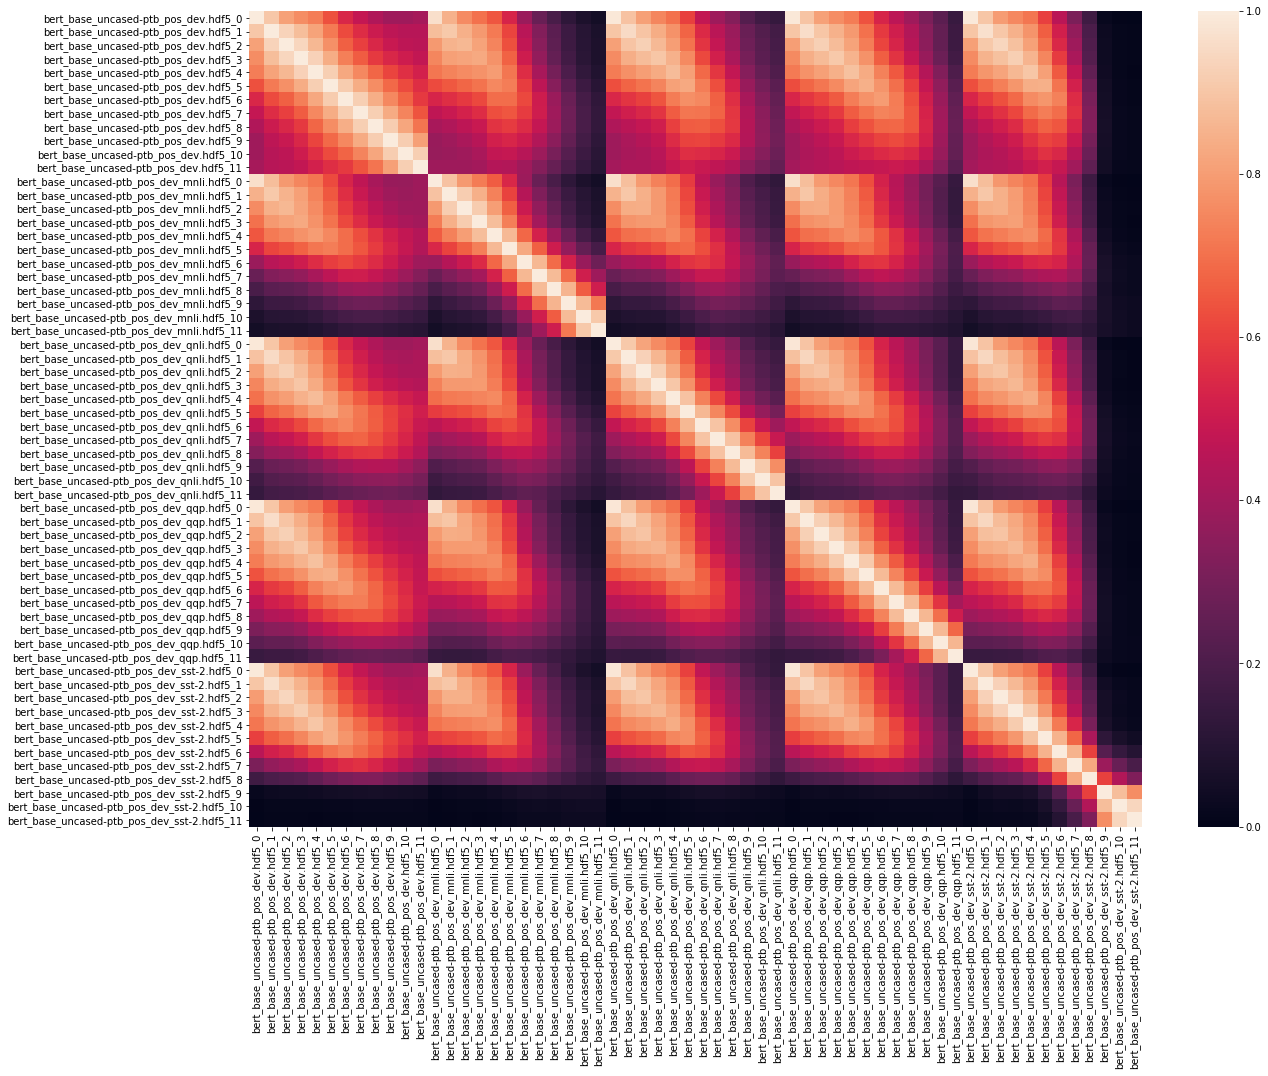

In [22]:
# lincka
sns.heatmap(lincka_df.fillna(1), vmin=0, vmax=1)

In [25]:
def corrs_update(fl, corr_df, fname_prefix, weights_df=None):
    fname = "{0}{1:.2f}.png".format(fname_prefix, fl)
    try:
        im = plt.imread(fname)
        plt.imshow(im)
    except:
        if weights_df is None: # eg. svcca, don't need to do special division
            df = corr_df.applymap(lambda t: float('nan') if type(t) is float else 
                                              t[:int(fl*len(t))].mean())
        else:
            denominator_df = weights_df.applymap(lambda t: float('nan') if type(t) is float else 
                                                             t[:int(fl*len(t))].sum())
            df = corr_df.applymap(lambda t: float('nan') if type(t) is float else
                                            t[:int(fl*len(t))].sum())
            df /= denominator_df
        sns.heatmap(df.fillna(1), vmin=0, vmax=1)
        # sns.heatmap(df.fillna(1), )
        plt.savefig(fname, transparent=True)
        plt.show()

In [26]:
# interactive updates
def pw_update(fl):
    corrs_update(fl, pw_corrs_df, "temp_fine_pw1_", weights_df=pw_alignments_df)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(pw_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [27]:
# interactive updates
def sv_update(fl):
    corrs_update(fl, sv_corrs_df, "temp_fine_sv1_", weights_df=None)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(sv_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [28]:
# interactive for maxmincorr
maxmin_corrs = res_d['maxcorr']['corrs']
maxmin_corrs_df = pd.DataFrame(maxmin_corrs).applymap(lambda a: float('nan') if type(a) is float else -np.sort(-a)) # np sort has no reverse keyword
maxmin_corrs_df = maxmin_corrs_df.reindex(maxmin_corrs_df.columns)
def maxmincorr_update(fl):
    corrs_update(fl, maxmin_corrs_df, "temp_fine_maxmincorr1_", weights_df=None)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(maxmincorr_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [29]:
# interactive for linregcorr
linreg_corrs = res_d['maxlinreg']['pred_power']
linreg_corrs_df = pd.DataFrame(linreg_corrs).applymap(lambda a: float('nan') if type(a) is float else -np.sort(-a)) # np sort has no reverse keyword
linreg_corrs_df = linreg_corrs_df.reindex(linreg_corrs_df.columns)
def linregcorr_update(fl):
    corrs_update(fl, linreg_corrs_df, "temp_fine_linregcorr1_", weights_df=None)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(linregcorr_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [ ]:
# rbfcka
# sns.heatmap(rbfcka_df.reindex(rbfcka_df.columns).fillna(1), vmin=0, vmax=1)

In [9]:
# comparing models
# use lincka
model1 = "xlnet"
model2 = "xlnet"
cols = [s for s in lincka_df.columns if s.find(model1) >= 0]
rows = [s for s in lincka_df.columns if s.find(model2) >= 0]

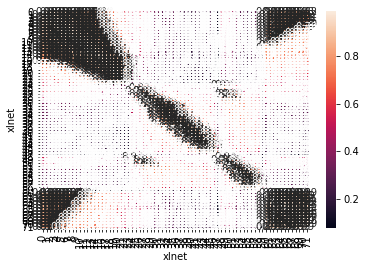

In [10]:
df = lincka_df.loc[rows, cols]

sns.heatmap(df, xticklabels=range(len(df.columns)), yticklabels=range(len(df.index)), annot=True)
plt.xlabel(model1)
plt.ylabel(model2)
plt.show()